# Technical Analysis  Workflow

According to Investopedia 'Technical Analysis is a trading discipline employed to evaluate investments and identify trading opportunities by analyzing statistical trends gathered from trading activity, such as price movement and volume'. It further states 'technical analysts focus on patterns of price movements, trading signals ... to evaluate a security's strength or weakness'.

In this workflow I am going to use the following TA indicators
* Simple Moving Averages
* Relative Strength Index 
* Stochastic Oscillator

The indicators will be used to generate Buy or Sell trading signals. There are several articles on the internet which attempt the same thing - often focusing on a single indicator - and most of these run the analysis on historical data, present the results and stop there.

However, for this workflow I want to take this a step further by continuing to run the analysis on an ongoing basis at a configured interval - e.g. every minute, hour, day (I did look at using realtime tick data as well but it was pointed out that this does not make much sense from a technical analysis perspective - as the ticks do not occur at regular interval).  
Furthermore, when a trading signal is generated I will use a chat BOT to post the signal details into a chat room notifying its users.

I have access to the Refinitiv Eikon desktop application so will be using its Data API - which can access historical, reference and realtime streaming data. I will also use symbology conversion functions to convert from ISINs to RIC (Reuters Instrument Codes) for requesting the various data. In addition, I will use the Refinitiv <a href="https://developers.refinitiv.com/messenger-api" target="_blank">Messenger BOT API</a> to post message to a RM Chatroom.

Before we go any further I should mention that I am relatively new to the Eikon Data API and to Python itself - so you may come across 'not very Pythonic' ways of doing things. If you find instances which border on sacrilege (in the Python world) please let me know and I will try and amend the offending code (I am working on the `lower_case_with_underscores` naming convention - but as a long time Java/C++ developer not there yet!). 

#### TA-Lib : Technical Analysis Library
Initially, when I started out, I was using using various Python scripts/snippets I found online for calculating my indicators and then wondering just how accurate they may truly be.
After spending (wasting?) some considerable time testing and fretting about the veracity of these snippets, a colleague (thank you Jason!) mentioned that there already existed a Python wrapper - <a href="https://github.com/mrjbq7/ta-lib" target="_blank">ta-lib</a> - for the *well known* Technical Analysis Library - <a href="https://ta-lib.org/hdr_doc.html" target="_blank">TA-Lib</a>. Off course - this being Python there would have to be a library for it (remember - Python noob!).


#### Import our libraries

I think I should mention the versions of some of the key libraries I have installed - just in case you have any issues:  
eikon - 1.1.3a0  
pandas - 1.0.0  
numpy - 1.18.1  
talib - 0.4.17  
matplotlib - 3.1.3  

I have used an alpha release of the `eikon` library version because I wanted to test it & the `pandas.np deprecation warnings` were bugging me. If you have the official v1.1.2 installed it should still work fine and you could just `import warnings` library and use `warnings.filterwarnings("ignore")` to supress them.  
If you are working on Windows and decide to build the TA-Lib binaries (rather than download the prebuilt ones) pay attention to the instructions on moving the folder (otherwise you may be scratching your head as to why it won't build properly)!

To post messages to the Refinitiv (Eikon) Messenger Chatroom I am using the existing *Messenger BOT API* example <a href="https://github.com/Refinitiv-API-Samples/Example.MessengerChatBot.Python" target="_blank">MessengerChatBot.Python</a>  from Github - full details are provided on the site.

In [1]:
import eikon as ek
import pandas as pd
import numpy as np
import talib as ta
import pause
import chatbot_demo_rest as cdr
import sys,os
import logging
from rdp_token import RDPTokenManagement
from datetime import datetime
from dateutil.relativedelta import relativedelta
from IPython.display import display
import matplotlib.pyplot as plt
import matplotlib.cbook as cbook
import matplotlib.gridspec as gridspec
from matplotlib.ticker import Formatter
from pandas.plotting import register_matplotlib_converters
register_matplotlib_converters()


#### Simple Moving Averages

This function uses the TA-Lib SMA function to calculate the Simple Moving Average using the Close price for two periods - which you will note later are 14 for the short period and 200 for the long period.
As you will see later, the period interval itself can vary e.g minute, daily, monthly, hourly - so for example, calculate SMA for 14 days and 200 days.

With the calcuated SMAs, it then uses the following logic to generate Buy and Sell signals:
* If short period SMA crosses up through the long period SMA then this is a buy signal
* If short period SMA crosses down through the long period SMA then this is a sell signal


In [2]:
def SMA(close,sPeriod,lPeriod):
    shortSMA = ta.SMA(close,sPeriod)
    longSMA = ta.SMA(close,lPeriod)
    smaSell = ((shortSMA <= longSMA) & (shortSMA.shift(1) >= longSMA.shift(1)))
    smaBuy = ((shortSMA >= longSMA) & (shortSMA.shift(1) <= longSMA.shift(1)))
    return smaSell,smaBuy,shortSMA,longSMA

The smaSell and smaBuy Series will contain the date/time and a flag to indicate a signal e.g. for a daily interval

    Date
    2018-02-15    False
    2018-02-16    False
    2018-02-19    True
    2018-02-20    False


#### Relative Strength Index
RSI calculation is usually done of a 14 day period - so once again I feed in the Close price for the instrument to the TA-Lib RSI function.
The common methodology is to set high and low thresholds of the RSI at 70 and 30. The idea being that if the if the lower threshold is crossed the asset is becoming oversold and we should buy. Conversely, if the upper threshold is crossed then the asset is becoming overbought and we should sell.

In [3]:
def RSI(close,timePeriod):    
    rsi = ta.RSI(close,timePeriod)
    rsiSell = (rsi>70) & (rsi.shift(1)<=70)
    rsiBuy = (rsi<30) & (rsi.shift(1)>=30)
    return rsiSell,rsiBuy, rsi

As per my SMA funcion, my RSI function also returns a Series containing date/time and a flag to indicate buy / sell signals 

#### Stochastics
The TA-Lib Stoch function returns two lines slowk and slowd which can then be used to generate the buy/sell indicators.  
A crossover signal occurs when the two lines cross in the overbought region (commonly above 80) or oversold region (commonly below 20).  
When a slowk line crosses below the slowd line in the overbought region it is considered a sell indicator.    
Conversely, when an increasing slowk line crosses above the slowd line in the oversold region it is considered a buy indicator.   

In [4]:
def Stoch(close,high,low):    
    slowk, slowd = ta.STOCH(high, low, close)
    stochSell = ((slowk < slowd) & (slowk.shift(1) > slowd.shift(1))) & (slowd > 80)
    stochBuy = ((slowk > slowd) & (slowk.shift(1) < slowd.shift(1))) & (slowd < 20)
    return stochSell,stochBuy, slowk,slowd

### We have a Trade Signal - so send it to the Chat Room!
I need a way of letting users know that a Trade singnal has been generated by the Technical Analysis. So, I am going to use the Messenger BOT API to send messages to other Refinitiv Messenger users. I am re-purposing the existing  <a href="https://github.com/Refinitiv-API-Samples/Example.MessengerChatBot.Python" target="_blank">MessengerChatBot.Python</a> example from GitHub.  


In [5]:
def sendSignaltoChatBot(myRIC, signalTime, indicators):
    indicatorList = ','.join(indicators.values)
    message = f"TA signal(s) Generated : {indicatorList} at {signalTime} for {myRIC}"
    print(message)
    
    # Connect, login and send message to chatbot
    bot_username = '<bot username>'
    bot_password = '<bot password>'
    app_key = '<eikon app key>'

    log_level = logging.WARN
    save_stdout = sys.stdout 
    # chatbot_demo_rest is a bit too verbose - so disable std output
    sys.stdout = open(os.devnull, 'w')
    # Create and initiate RDPTokenManagement object
    rdp_token = RDPTokenManagement(
        bot_username, bot_password, app_key)
    # Authenticate with RDP Token service
    access_token = cdr.authen_rdp(rdp_token)
    if access_token:
        # List associated Chatrooms
        status, chatroom_respone = cdr.list_chatrooms(access_token)
        chatroom_id = chatroom_respone['chatrooms'][0]['chatroomId']
        # Join associated Chatroom
        joined_rooms = cdr.join_chatroom(access_token, chatroom_id)
        if joined_rooms:
            # Send a default message to a Chatroom
            cdr.post_message_to_chatroom(
                access_token, joined_rooms, chatroom_id, message)
            joined_rooms = cdr.leave_chatroom(access_token, joined_rooms, chatroom_id)
    # restore std out
    sys.stdout = save_stdout


### Run the Technical Analysis
Initially I will do a historical TA run, after which I will use this function to run the above 3 TA methodologies on the data I get as part of the ongoing Technical Analysis.  
I am going to repeat some of this code later in the main historical TA run loop - purely for ease of reading. 


In [6]:
def runAllTA(myRIC, data):
    
    price = data['CLOSE']
    high = data['HIGH']
    low = data['LOW']
        
    # Simple Moving Average calcs
    smaSell,smaBuy,shortSMA,longSMA = SMA(price,shortPeriod,longPeriod)
    # Do the RSI calcs
    rsiSell,rsiBuy,rsi = RSI(price,shortPeriod)
    # and now the stochastics 
    stochSell,stochBuy,slowk,slowd = Stoch(price, high, low)    

    # Now collect buy and sell Signal timestamps into a single df
    sigTimeStamps = pd.concat([smaSell, smaBuy, stochSell, stochBuy, rsiSell, rsiBuy],axis=1)
    sigTimeStamps.columns=['SMA Sell','SMA Buy','Stoch Sell','Stoch Buy','RSI Sell','RSI Buy']
    signals = sigTimeStamps.loc[sigTimeStamps['SMA Sell'] | sigTimeStamps['Stoch Sell'] |
                         sigTimeStamps['RSI Sell'] | sigTimeStamps['SMA Buy'] | 
                         sigTimeStamps['Stoch Buy'] | sigTimeStamps['RSI Buy']]
    
    # Compare final signal Timestamp with latest data TimeStamp
    if (data.index[-1]==signals.index[-1]):
        final = signals.iloc[-1]
        # filter out the signals set to True and send to ChatBot
        signal = final.loc[final]
        signalTime = signal.name.strftime("%Y-%m-%dT%H:%M:%S")
        indicators = signal.loc[signal].index
        sendSignaltoChatBot(myRIC, signalTime, indicators)


If the timestamp of the final TA signal, matches the timestamp of the most recent data point - then we have one or more new trade signal(s) - so inform the Chatroom users.

#### Timing Helper functions
I also need a couple of helper functions to calculate some time values based on the selected interval

In [7]:
# Calculate Start and End time for our historical data request window
def startEnd(interval):
    end = datetime.now()
    start = {
      'minute': lambda end: end - relativedelta(days=5),
      'hour': lambda end: end - relativedelta(months=2),
      'daily': lambda end: end - relativedelta(years=2),
      'weekly': lambda end: end - relativedelta(years=5),
      'monthly': lambda end: end - relativedelta(years=10),
    }[interval](end)
    return start.strftime("%Y-%m-%dT%H:%M:%S"),end.strftime("%Y-%m-%dT%H:%M:%S")

# How long to sleep for when running the ongoing 'realtime' analysis
def gotoSleep(interval):
    pauser = {
      'minute': lambda: pause.minutes(1),
      'hour': lambda: pause.hours(1),
      'daily': lambda: pause.days(1),
      'weekly': lambda: pause.weeks(1),
      'monthly': lambda: pause.days(30),
    }[interval]()

# How much of the timestamp to display in the summary table
# for interday show the date, intraday show time as well etc
def timeStampLength(interval):
    tsLen = {
      'minute': 16,
      'hour': 16,
      'daily': 10,
      'weekly': 10,
      'monthly': 10,
    }
    return tsLen[interval]    


### Plotting functions
Whilst not essential to the workflow, I wanted to plot a few charts to provide a visual representation of the various TA indicators - so we can try and visually tie up instances where a price rises or drops in line with a TA trade signal - so for example when the short SMA crosses up through the long SMA, do we see an upward trend in the price after that point in time?  

In [8]:
# Use a formatter to remove weekends from date axis 
# to smooth out the line.
class MyFormatter(Formatter):
    def __init__(self, dates, fmt='%Y-%m-%d'):
        self.dates = dates
        self.fmt = fmt

    def __call__(self, x, pos=0):
        'Return the label for time x at position pos'
        ind = int(round(x))
        if ind>=len(self.dates) or ind<0: return ''
        return self.dates[ind].strftime(self.fmt)
    
def plotSMAs(ric,close,sma14,sma200,sell,buy):
    x = close.index
    plt.rcParams["figure.figsize"] = (28,8)
    formatter = MyFormatter(x)
    fig, ax = plt.subplots(facecolor='0.25')
    ax.xaxis.set_major_formatter(formatter)
    ax.plot(np.arange(len(x)),close, label='Close',color='y')
    ax.plot(np.arange(len(x)),sma14,label="SMA 14", color='g')
    ax.plot(np.arange(len(x)),sma200,label="SMA 200", color='tab:purple')
    ax.tick_params(axis='both', colors='w')
    ax.set_facecolor('0.25')
    fig.autofmt_xdate()
    plt.ylabel('Close',color='y')
    plt.legend(loc='upper center',fontsize='x-large')
    plt.title(f"Simple Moving Average : {ric}",color='w')
    plt.show()

def plotRSI(ric,close,rsi):
    plt.rcParams["figure.figsize"] = (28,12)
    formatter = MyFormatter(rsi.index)
    fig = plt.figure(facecolor='0.25')
    gs1 = gridspec.GridSpec(2, 1)
    # RSI chart
    ax = fig.add_subplot(gs1[1])
    ax.xaxis.set_major_formatter(formatter)
    ax.plot(np.arange(len(rsi.index)), rsi.values,color='b')
    ax.tick_params(axis='both', colors='w')
    ax.set_ylabel('RSI', color='b')
    ax.set_facecolor('0.25')
    plt.axhline(y=70, color='w',linestyle='--')
    plt.axhline(y=30, color='w',linestyle='--')
    # Close Price chart
    axc = fig.add_subplot(gs1[0])
    axc.xaxis.set_major_formatter(formatter)
    axc.plot(np.arange(len(rsi.index)), close, color='y')
    axc.tick_params(axis='both', colors='w')
    axc.set_xticklabels([])
    axc.set_ylabel('Close', color='y')
    axc.set_facecolor('0.25')
    gs1.update(wspace=0.025, hspace=0.0)
    plt.title(f"Relative Strength : {ric}",color='w')
    plt.show()

def plotStoch(ric,close,slowK,slowD):
    plt.rcParams["figure.figsize"] = (28,12)
    formatter = MyFormatter(slowK.index)
    fig = plt.figure(facecolor='0.25')
    gs1 = gridspec.GridSpec(2, 1)
    ax = fig.add_subplot(gs1[1])
    # Stochastic lines chart
    ax.xaxis.set_major_formatter(formatter)
    ax.plot(np.arange(len(slowk.index)), slowk.values,label="Slow K",color='m')
    ax.plot(np.arange(len(slowk.index)), slowd.values,label="Slow D",color='g')
    ax.tick_params(axis='both', colors='w')
    plt.legend(loc='upper center',fontsize='x-large')
    plt.axhline(y=80, color='w',linestyle='--')
    plt.axhline(y=20, color='w',linestyle='--')
    # Closing price chart
    axc = fig.add_subplot(gs1[0])
    axc.xaxis.set_major_formatter(formatter)
    axc.set_ylabel('Close', color='y')
    axc.set_xticklabels([])
    axc.plot(np.arange(len(close.index)), close, color='y')
    axc.tick_params(axis='both', colors='w')
    gs1.update(wspace=0.025, hspace=0.0)
    plt.title(f"Stochastic : {ric}",color='w')
    ax.set_facecolor('0.25')
    axc.set_facecolor('0.25')
    plt.show()

### Connecting to the Eikon application
To connect to my running instance of Eikon I need to provide my Application Key.

In [9]:
ek.__version__
#import logging.config
#ek.set_log_level(logging.DEBUG)
ek.set_app_key('7bdffe94ef7f48a7a70d7511e5a5fd4cd6b0989a')

### Some initialisation code
I need to calculate the start and end date for my price query - based on the chosen periodicity/interval, as well as specify the periods for moving averages.  
Also, as I will be requesting the price of each instrument individually, I also create a container to hold all the price data for the full basket of instruments.  
Finally, I set some display properties for the Pandas dataframe.

In [10]:
myInterval = 'daily'    # 'minute', 'hour', 'daily', 'weekly', 'monthly'
myStart, myEnd  = startEnd(myInterval)
timestampLen = timeStampLength(myInterval)
print(f'Interval {myInterval} from {myStart} to {myEnd} : Timestamp Length {timestampLen}')
shortPeriod = 14
longPeriod = 200
basket={}
# Do we want to plot charts?
plotCharts = True
# Dataframe display setting
pd.set_option("display.max_rows", 999)
pd.set_option('precision', 3)

Interval daily from 2018-03-27T16:26:39 to 2020-03-27T16:26:39 : Timestamp Length 10


#### TA Analysis summary output
Once the initial historical TA has been run, I want to present a summary table of the signal over that period.  
For this I am going to use a Dataframe to output the results in a readable format.  
I am also creating some blank columns which I will use for padding the dataframe later.  

In [11]:
outputDF = pd.DataFrame(columns=['RIC','Name','ISIN','Close','Periodicity','Intervals Up',
                               'Intervals Down','Unchanged','1wk %ch','1M %ch','YTD %ch','6M %ch',
                               '1yr %ch','SMA Sell','SMA Buy','Stoch Sell','Stoch Buy','RSI Sell', 'RSI Buy' ])
blankSignalCols = ['N/A']*6
blankNonSignalCols = [' ']*13

#### Convert my ISIN symbols to RICs
Whilst Eikon can accept various Symbology types for certain interactions, I need to specify RICs (Reuters Instrument Code) for much of the data I intend to access.  
Therefore, I could just start with a bunch of RICs - but not everyone works with RICs - so here is an example of symbology conversion at work.  

In [12]:
myISINs = [   
    'GB0002634946',
#     'GB0006731235',
#     'GB00B02J6398',
#     'GB00B1XZS820',
#     'GB0000456144',
#     'GB0000536739',
#     'GB0009895292',
#     'GB0002162385',
#     'GB0009697037',
    'GB00B1YW4409'
]
myRICs = ek.get_symbology(myISINs, from_symbol_type='ISIN', to_symbol_type='RIC')

Just for your reference, the `get_symbology` function can accept *from* and *to* symbol types of 
* CUSIP
* ISIN
* SEDOL
* RIC
* ticker
* lipperID
* IMO

In addition you can also convert to the 'OAPermID' type.

#### Snapshot some summary data values
Once I have run the TA I want to present a summary table reflecting the price changes for each instrument over various periods such as week, month, year etc - along with the TA results.  
So, for this I am using the `get_data` method to obtain various Percent price change values as as well the name of the corporate entity and the most recent Closing price.

In [13]:
listRICs = list(myRICs.RIC)
pcts, err = ek.get_data(
    instruments = listRICs,
    fields = [
        'TR.CommonName',
        'TR.CLOSEPRICE',
        'TR.PricePctChgWTD',
        'TR.PricePctChgMTD',
        'TR.PricePctChgYTD',
        'TR.PricePctChg6M',
        'TR.PricePctChg1Y',
    ]
)
pcts.set_index('Instrument',inplace=True)

In the above call, I am requesting each instruments percent Price change for Week, Month and Year to Date - and the 6m and 1yr period as well.


### Putting it all together for our initial 'historical' analysis run
I can now go ahead and request my historical data and perform the Technical Analysis.
As well as intervalised data at minute, hour, daily etc Eikon product can also provide tick data - i.e. individual trades as well as Bid//Ask changes.
However, there are some difference in the data set for tick data compared to the other intervals:
* Historical tick data will be indexed on the date+time of every tick - and therefore the index can vary across instruments
* Intervalised data will be indexed according to the interval e.g. every minute, hour etc and therefore use the same index values across multiple instruments
* I can get high,low prices for intervalised data (which is needed for the Stochastic TA) but not for tick data  

As you can see since the tick data is not intervalised, it does not make sense from a TA point of view. 
Note that for interval data, I can specify multiple RICs in the `get_timeseries` call and get back a single dataframe with the prices for all the RICs. However, to make the code easier to read, I will loop through the RICs and request each one individually rather than slightly increased subsequent complication involved if I have to use a single dataframe containing all the data.

After requesting the data, I calculate values for Price Up, Down and no change movements for the analysis period. Then I call the various TA functions to calculate the indicators and generate the signals (& plot charts if enabled).  
Finally I use the data and signals etc to generate a dataframe displaying a summary of the various stats + signals for our configured TA time period and interval.


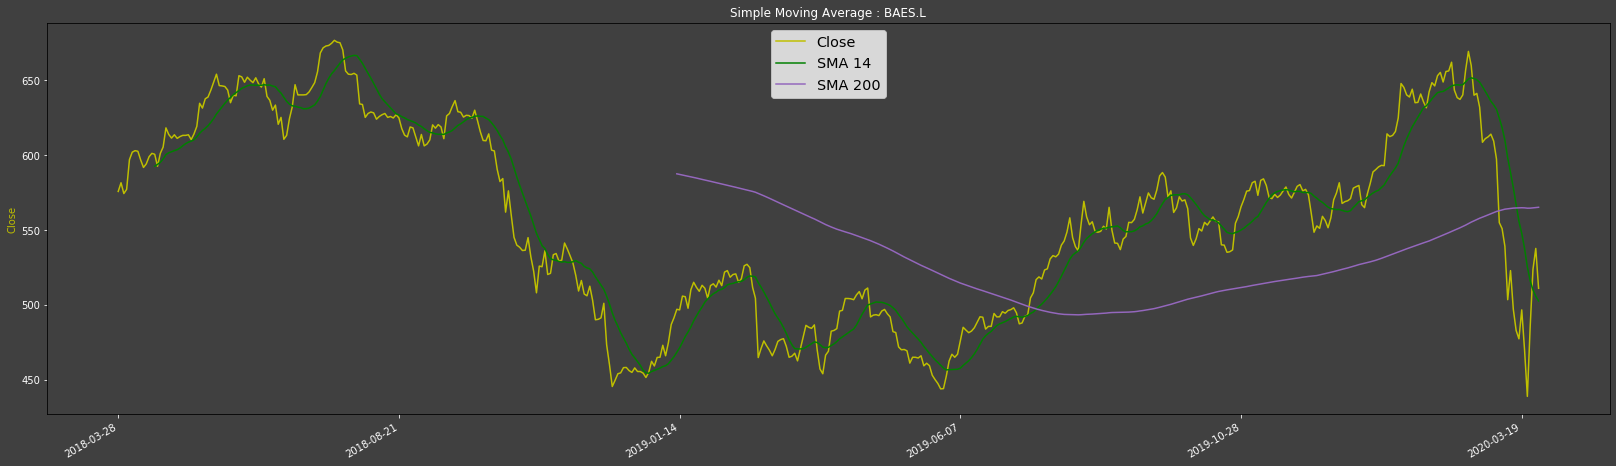

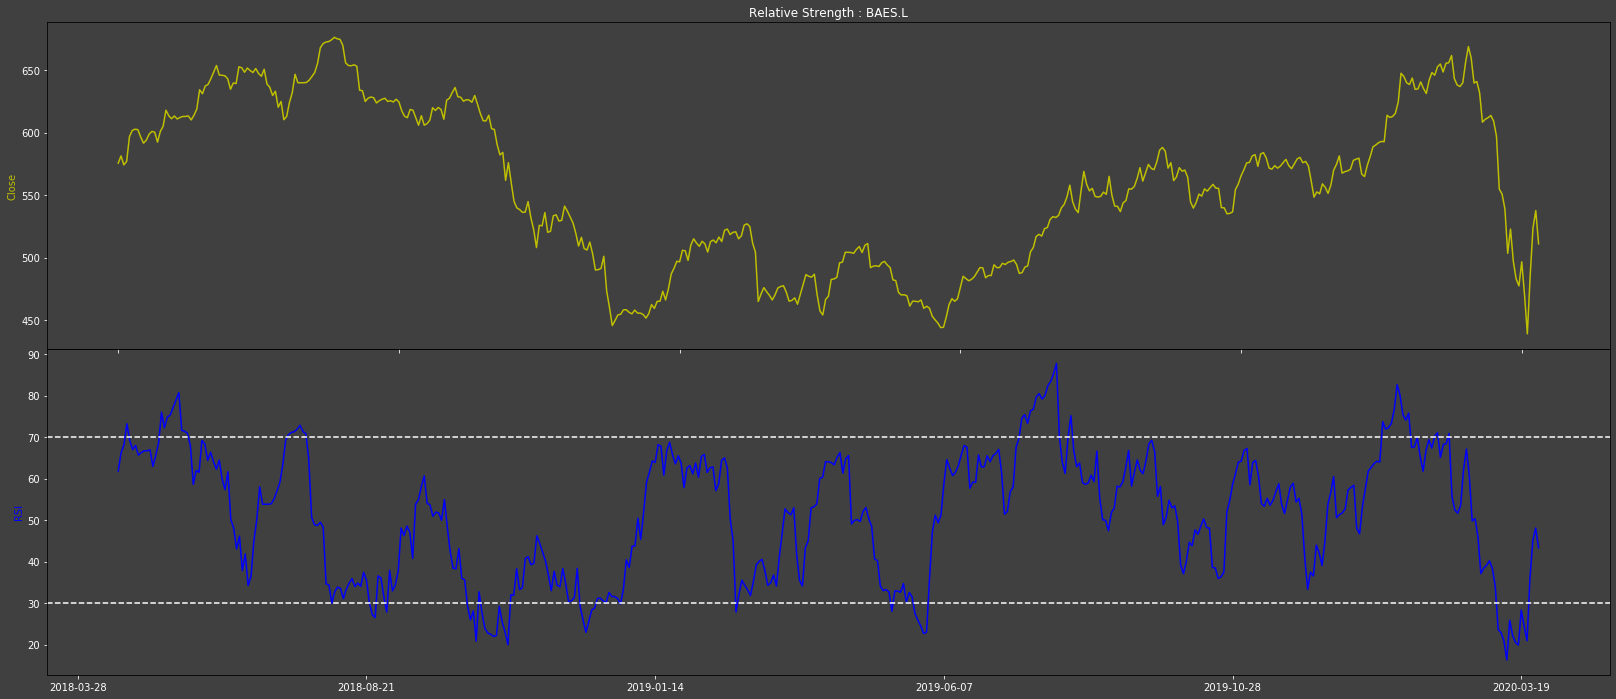

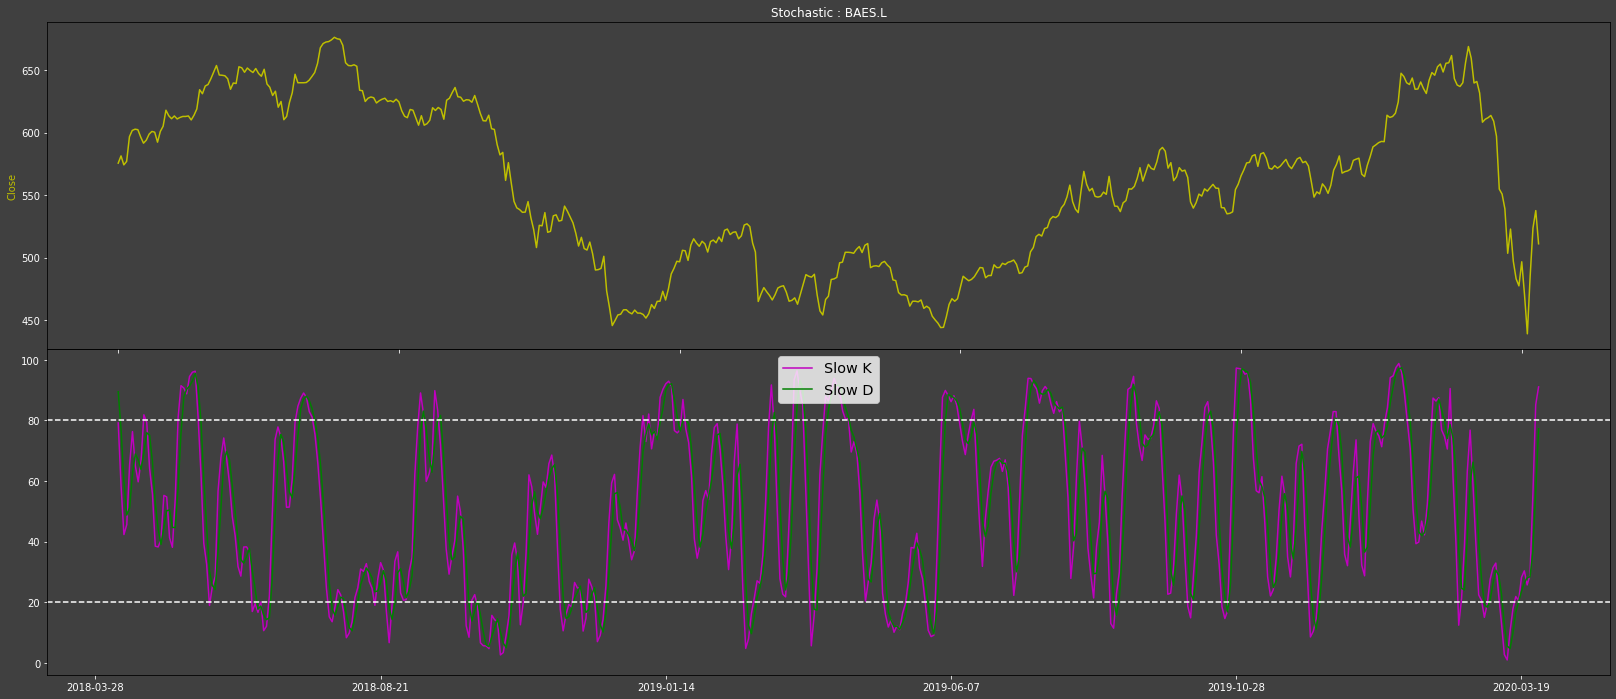

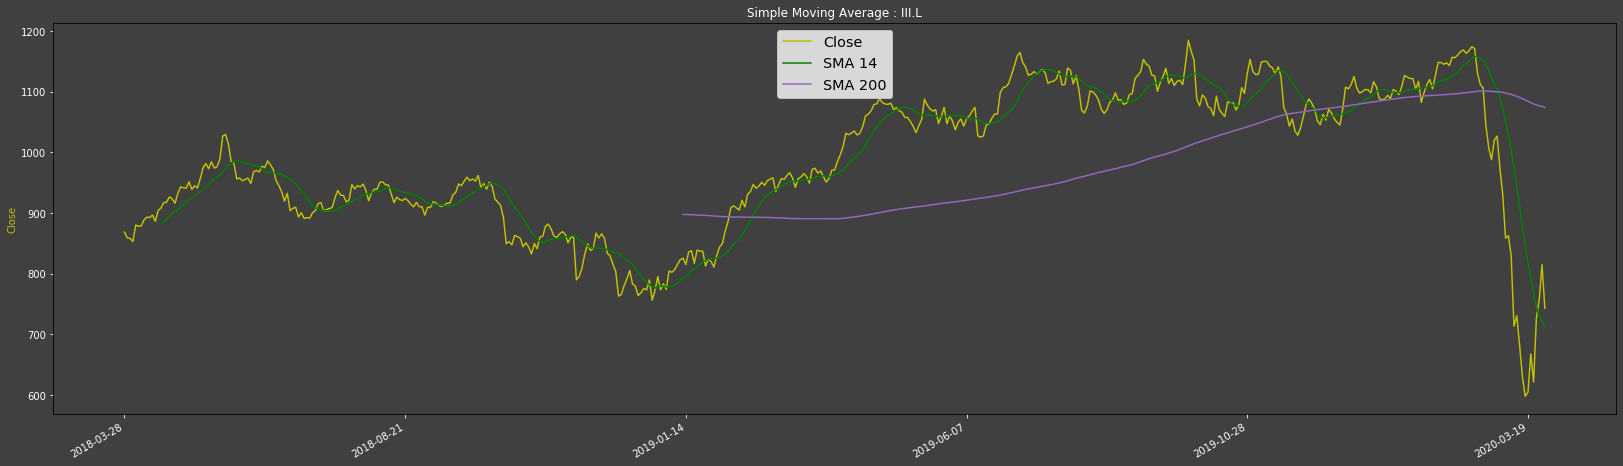

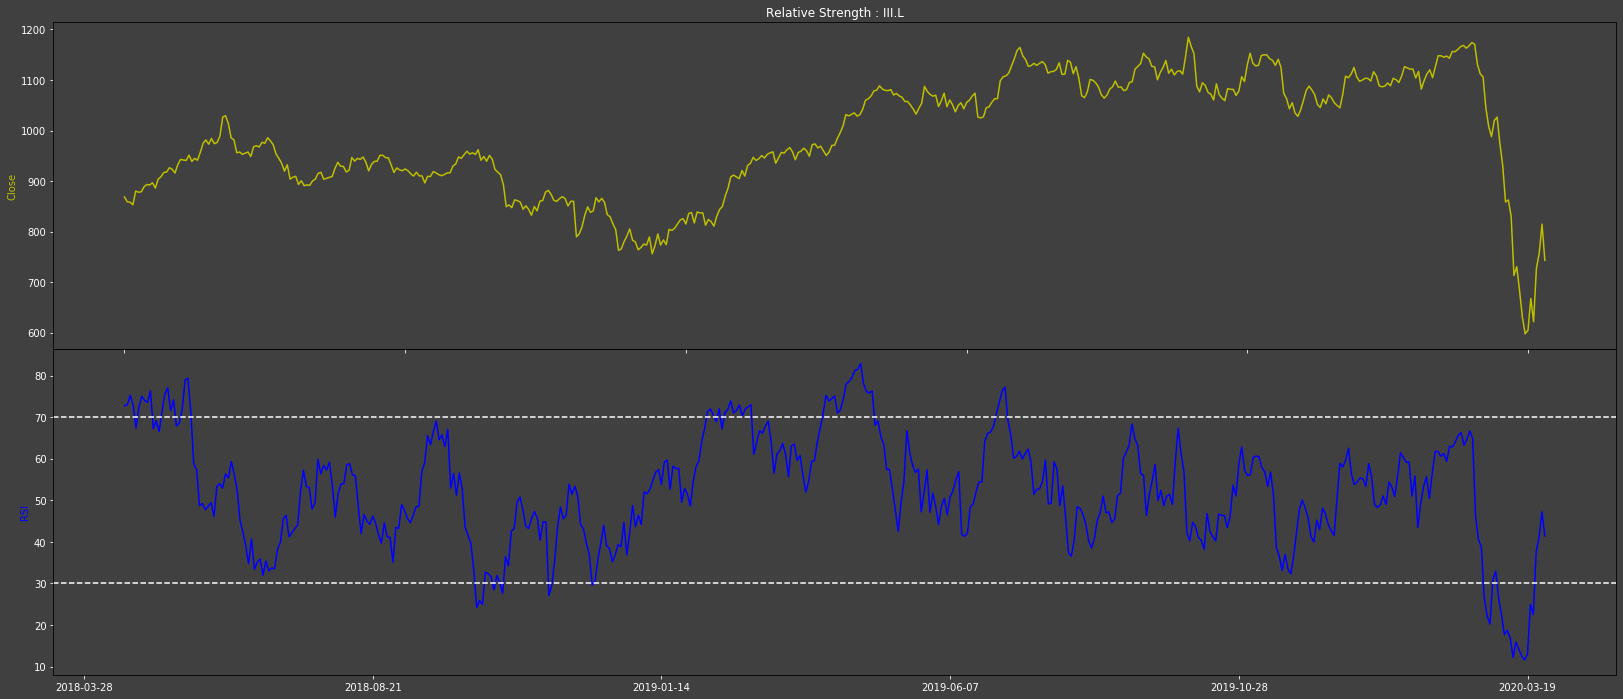

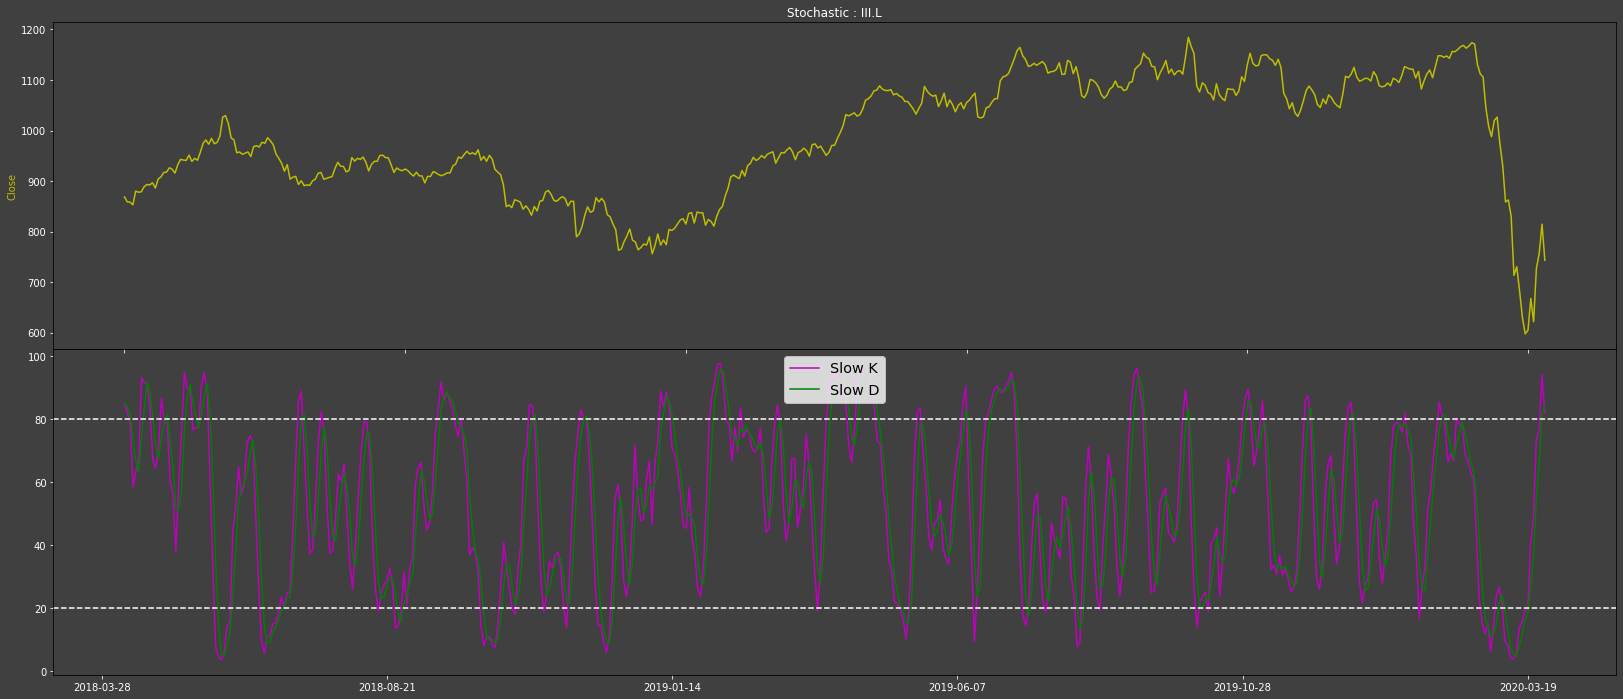

In [14]:
for ISIN, symb in myRICs.iterrows():
    myRIC=symb['RIC']
    data = ek.get_timeseries(myRIC,  
        fields = ['CLOSE','HIGH','LOW'],
        start_date=myStart,  
        end_date=myEnd,
        interval = myInterval)  
    price = data['CLOSE']
    high = data['HIGH']
    low = data['LOW']
    
    basket[myRIC]=data # Save each instrument's raw data for later use

    # Count Price Up, Down and No change
    upCnt = (price < price.shift(1)).value_counts().loc[True]
    downCnt = (price > price.shift(1)).value_counts().loc[True]
    try:
        ncCnt = (price == price.shift(1)).value_counts().loc[True]
    except KeyError as e:
        ncCnt = 0
    
    # Do the Simple Moving Average calcs
    smaSell,smaBuy,shortSMA,longSMA = SMA(price,shortPeriod,longPeriod)
    if plotCharts:
        plotSMAs(myRIC,price,shortSMA,longSMA,smaSell,smaBuy)
            
    # Do the RSI calcs
    rsiSell,rsiBuy,rsi = RSI(price,shortPeriod)
    if plotCharts:
        plotRSI(myRIC,price,rsi)

    # Stochastic calcs
    stochSell,stochBuy,slowk,slowd = Stoch(price, high, low)
    if plotCharts:
        plotStoch(myRIC,price,slowk,slowd)
    
    # Get the Percent Change data for thisRIC
    pct = pcts.loc[myRIC]
    
    # Now we build the summary table
    # starting with the non-trade signal related stuff
    nonSignalData = [myRIC,
                         pct['Company Common Name'],
                         ISIN,
                         pct['Close Price'],
                         myInterval,
                         upCnt,downCnt,ncCnt,
                         pct['WTD Price PCT Change'],
                         pct['MTD Price PCT Change'],
                         pct['YTD Price PCT Change'],
                         pct['6-month Price PCT Change'],
                         pct['1-year Price PCT Change']]
    
    # Now build the Signal buy and sell columns for each TA indicator
    sigTimeStamps = pd.concat([smaSell, smaBuy, stochSell, stochBuy, rsiSell, rsiBuy],axis=1)
    sigTimeStamps.columns=['SMA Sell','SMA Buy','Stoch Sell','Stoch Buy','RSI Sell','RSI Buy']
    signals = sigTimeStamps.loc[sigTimeStamps['SMA Sell'] | sigTimeStamps['Stoch Sell'] |
                         sigTimeStamps['RSI Sell'] | sigTimeStamps['SMA Buy'] | 
                         sigTimeStamps['Stoch Buy'] | sigTimeStamps['RSI Buy']]

    # If any trade signals were generated for our time period
    # add them to the summary table
    signalCnt = len(signals)
    if (signalCnt):
        first = True
        for index,row in signals.iterrows():
            sigDate = str(index)[0:timestampLen]
            signalList = [sigDate if item else "" for item in row]
            # First row to contain non-signal stuff, subsequent rows only trade signals
            tempRow = nonSignalData.copy() if first else blankNonSignalCols.copy()
            tempRow.extend(signalList)
            s = pd.Series(tempRow, index=outputDF.columns)
            outputDF = outputDF.append(s,ignore_index=True)
            first=False
    else:  # No signals so just the non-signal related stuff
        tempRow = nonSignalData.copy()
        tempRow.extend(blankSignalCols)
        outputDF = outputDF.append(tempRow)


In [15]:
outputDF.head(5)

,RIC,Name,ISIN,Close,Periodicity,Intervals Up,Intervals Down,Unchanged,1wk %ch,1M %ch,YTD %ch,6M %ch,1yr %ch,SMA Sell,SMA Buy,Stoch Sell,Stoch Buy,RSI Sell,RSI Buy
0,BAES.L,BAE Systems PLC,GB0002634946,538,daily,231,268,7,14.4,-11.6,-4.82,-6.01,18.4,,,,,2018-04-24,
1,,,,,,,,,,,,,,,,,,2018-05-11,
2,,,,,,,,,,,,,,,,2018-05-16,,,
3,,,,,,,,,,,,,,,,2018-05-22,,,
4,,,,,,,,,,,,,,,,,2018-06-22,,


In [16]:
outputDF.tail(5)

,RIC,Name,ISIN,Close,Periodicity,Intervals Up,Intervals Down,Unchanged,1wk %ch,1M %ch,YTD %ch,6M %ch,1yr %ch,SMA Sell,SMA Buy,Stoch Sell,Stoch Buy,RSI Sell,RSI Buy
110,,,,,,,,,,,,,,,,,2020-02-28,,
111,,,,,,,,,,,,,,,,,2020-03-03,,
112,,,,,,,,,,,,,,2020-03-05,,,,,2020-03-05
113,,,,,,,,,,,,,,,,,2020-03-13,,
114,,,,,,,,,,,,,,,,2020-03-27,,,


#### Output Summary table
After the initial Technical Analysis run using the historical data, I want to output a summary table with some basic stats s well as history of the Trade signals for the configured Interval and Time Period.  

For the stats, I display the Percent change for various periods such as Week to Day, Month to Day, 6 months - in order to provide a indication of just how the particular stock has been trading over those time periods. I also display the number of intervals where the price has gone up, down or no change as potentially useful reference points.  

The rightmost columns of the table contain the Buy and Sell signals occurences for the 3 TA methodologies - one row for each date/time that triggered a signal - you may occasionally see more than one signal in a single row. For example, whilst I was testing both RSI and Stoch indicated Buy signals on 11th October 2018 for the 3i Group (III.L). You may find the <a href="https://www.reuters.com/companies/III.L/charts" target="_blank">3 yr chart for III</a> interesting...


### Ongoing Technical Analysis

Now that I have the historical analysis out of the way, I will move onto the ongoing *'real time'* analysis. In other words, I will leave the script running to perform the TA on an ongoing basis at the configured interval.  

The simplest approach would be to just make the above `get_timeseries` calls with a revised `start_date` and `end_date` parameters. However, this would be quite wasteful of resources and so I will request just the latest data point for my configured interval.  
To do this, I make the call with `count=1` (rather than Start/End times) to get just the latest data point. I then drop the earliest data point from our historical data points and append the latest one.  
I can then run the Technical Analysis with the most recent data included.  


In [ ]:
while True:
    gotoSleep(myInterval)
    for myRIC in listRICs:
        historical = basket[myRIC]
        latest = ek.get_timeseries(myRIC,fields = ['CLOSE','HIGH','LOW'],
                                   count = 1, interval = myInterval)  
        # Delete earliest data point
        historical.drop(historical.index[0])
        # Append latest data point
        historical = historical.append(latest)
        runAllTA(myRIC, historical)
        # Udpate basket with latest values
        basket[myRIC] = historical
        

### Closing Summary
I could now leave this script running with my preferred interval and it will send Messages to the chatroom each time the Technical Analaysis yields a Buy or Sell signal, like the ones shown below:

![](RM_BOT.png)

Note: For the above screen capture, I set the interval to 'minute' in an attempt to generate signals sooner rather than later.

For a trader who uses Simple Moving Average, Relative Strength Indices and/or Stochastic charts to help inform their trading decisions - this could mean they don't need to actively sit there eyeballing charts all day long.

I hope you found this exercise useful and no doubt there are many possible improvements/refinements that could be made to both the code and the simple TA methodology I have used. 
A few worth considering:
* In the Summary table above we see that the SMA based TA is indicating a Sell whereas the RSI based TA is indicating a Buy - which could suggest that further refinements are required? 
* I read in an article about RSI, that once the line crosses a threshold it may be better to wait till it crosses back in the opposite direction before generating a signal - so for example, if the crosses below %30, wait till it crosses back up above 30% before generating a Buy signal.
* In my summary output table, I show the '% change' for week, month, year etc - which is relevant for my 'daily' interval based TA - but not so much if say I used a 'hourly' interval. My colleague (Jason again!) suggested that a better approach could be to show '% change' values for say Hourt, Hour t+1, t+5, t+10 etc as per my chosen interval.
* Another improvement could be to show up/down markers on the plot lines highlighting the crossover points.

There is no shortage of material on Technical Analysis to be found on the internet. 

**NOTE:** It goes without saying that I don't endorse the above code as something that should be used for active trading - it is purely an educational example.